# Asynchronous Initialization 

#### RTM Cell

$\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$

$\beta_{n} = 0.5*e^{-(v+57)/40}$

$\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$

$\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$

$\alpha_{h} = 0.128*e^{-(v+50)/18}$

$\beta_{h} = 4./(1+e^{-(v+27)/5})$

In [1]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =30

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Initialize "frozen noise" for current clamp and RTM synapse strength

In [2]:
i_ext= np.random.rand(n_E,1)*0.1+0.25

#create array of start times for heterogeneous initialization
start = np.random.rand(n_E,1)* 25 # array of 30 with times from 0 to 25
print(start)

[[10.67154863]
 [ 7.02425437]
 [ 5.54661866]
 [ 5.88836194]
 [22.69630117]
 [12.18200326]
 [10.29683655]
 [ 0.33349339]
 [ 4.32223687]
 [ 3.45720635]
 [ 7.58104598]
 [ 2.06851459]
 [17.71048196]
 [ 1.81207219]
 [14.905722  ]
 [ 5.28440559]
 [10.31173282]
 [11.43363428]
 [12.85569734]
 [16.40336937]
 [ 1.31975415]
 [ 2.52290636]
 [12.5549299 ]
 [18.90604373]
 [ 0.76044812]
 [14.73557283]
 [20.31735982]
 [ 2.68273522]
 [ 2.0952136 ]
 [18.73681122]]


Add excitatory connection from each RTM cell to every other RTM cell in the network and save

In [3]:
# add 1 synaptic connection from each cell to every other cell avoiding self connections
def like2like(source, target):
    """A simple function for setting # of synaptic connections based on pop-name attribute. """
    if source['node_id'] == target['node_id']:
        # No autapses
        return 0

    # 1 connection otherwise
    return 1


def rand_syn_weight(source, target, min_weight, max_weight):
    sec_x=0.5
    sec_id=0
    return np.random.uniform(min_weight, max_weight), sec_x, sec_id


conn = net.add_edges(source={'pop_name': 'Exc'}, target={'pop_name': 'Exc'},
              connection_rule=like2like, # Note that we are passing in the function name but not calling it
              connection_params={}, # 1 synaptic connection to all other cells
              target_sections=['soma'],
              dynamics_params='PING_ExcToExc.json',     
              model_template='exp2syn',
              delay=0)

conn.add_properties(['syn_weight','sec_x','sec_id'],
                    rule=rand_syn_weight,
                    rule_params={'min_weight': 0.00625, 'max_weight': 0.00825},
                    dtypes=[np.float, np.uint, np.uint])




Build and save connections

In [4]:
net.build()
net.save_nodes(output_dir='network')
net.save_edges(output_dir='network')

In [5]:
extnet = NetworkBuilder('extnet')
extnet.add_nodes(N=30,pop_name='Inp',
            potential='exc',
            model_type='virtual')

In [8]:
extnet.add_edges(source={'pop_name':'Inp'}, target=net.nodes(),
                   iterator='one_to_one',
                   connection_rule=1,
                   syn_weight=0.195,               #synaptic weight specified in Borger's book ch 23
                   delay=5,
                   weight_function=None,
                   target_sections=['soma'],
                   distance_range=[0.0, 150.0],
                   dynamics_params='PING_ExcToExc.json',
                   model_template='exp2syn')

In [9]:
extnet.build()
extnet.save_nodes(output_dir='network')
extnet.save_edges(output_dir='network')

We now need to create an initial spike for each of our cells with varying phase

In [10]:
from bmtk.utils.reports.spike_trains import SpikeTrains

spikes = SpikeTrains(population='extnet')
for i in range(30):
    print(start[i])
    spikes.add_spikes(node_ids=i,timestamps=[start[i]])
spikes.to_sonata('input/Asynchronous.h5')

[10.67154863]
[7.02425437]
[5.54661866]
[5.88836194]
[22.69630117]
[12.18200326]
[10.29683655]
[0.33349339]
[4.32223687]
[3.45720635]
[7.58104598]
[2.06851459]
[17.71048196]
[1.81207219]
[14.905722]
[5.28440559]
[10.31173282]
[11.43363428]
[12.85569734]
[16.40336937]
[1.31975415]
[2.52290636]
[12.5549299]
[18.90604373]
[0.76044812]
[14.73557283]
[20.31735982]
[2.68273522]
[2.0952136]
[18.73681122]


The RTM neurons also have a current clamp input that was defined earlier in our "frozen noise"

In [11]:
import h5py


dts = [1]
gids = "all"

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Building the Simulation Environment

In [12]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=200.0, dt=0.1,
                 report_vars=['v'],     # Record membrane potential and calcium (default soma)
                 spikes_inputs=[('network',   # Name of population which spikes will be generated for
                                'input/Asynchronous.h5')],
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False   # Will try to compile NEURON mechanisms
                )

### Running the Simulation

In [13]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('simulation_config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2021-01-18 18:29:23,927 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2021-01-18 18:29:24,055 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2021-01-18 18:29:24,098 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2021-01-18 18:29:25,234 [INFO] Building virtual cell stimulations for network_spikes


INFO:NEURONIOUtils:Building virtual cell stimulations for network_spikes


2021-01-18 18:29:25,286 [INFO] Running simulation for 200.000 ms with the time step 0.100 ms


INFO:NEURONIOUtils:Running simulation for 200.000 ms with the time step 0.100 ms


2021-01-18 18:29:25,308 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2021-01-18 18:29:25,338 [INFO] Block save every 2000 steps


INFO:NEURONIOUtils:Block save every 2000 steps


2021-01-18 18:29:26,556 [INFO]     step:2000 t_sim:200.00 ms


INFO:NEURONIOUtils:    step:2000 t_sim:200.00 ms


2021-01-18 18:29:26,601 [INFO] Simulation completed in 1.315 seconds 


INFO:NEURONIOUtils:Simulation completed in 1.315 seconds 


In [14]:
from bmtk.analyzer.spike_trains import plot_raster, plot_rates_boxplot

plot_raster(config_file='simulation_config.json', group_by='pop_name')

c:\users\strou\anaconda3\envs\py2env\lib\site-packages\bmtk-0.0.8-py2.7.egg\bmtk\simulator\utils\config.py:4: UserWarning: Please use bmtk.simulator.core.simulation_config instead.
  warnings.warn('Please use bmtk.simulator.core.simulation_config instead.')


IndexError: list index out of range

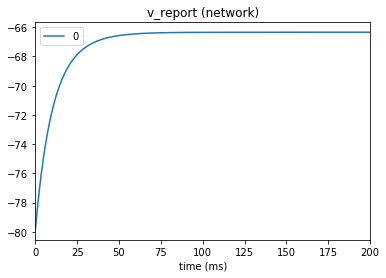

In [15]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='simulation_config.json', node_ids=[0], report_name='v_report')

In [16]:
from bmtk.analyzer.spike_trains import to_dataframe

results_df = to_dataframe(config_file='simulation_config.json')
print('Number of Spikes: {}'.format(len(results_df)))
results_df.head()

IndexError: list index out of range